In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Parameters
tickers = ['JNJ', 'NVDA', 'META', 'GOOGL']
sequence_length = 30
batch_size = 64
hidden_size = 50
num_epochs = 10
learning_rate = 0.001

# Download stock data
def get_stock_data(ticker):
    df = yf.download(ticker, start="2015-01-01", end="2023-12-31")
    return df[['Close']]

# Concatenate multiple stocks
data = pd.concat([get_stock_data(t) for t in tickers], axis=1)
data.columns = tickers
data.dropna(inplace=True)

# Normalize
scalers = {}
scaled_data = pd.DataFrame()
for ticker in tickers:
    scaler = MinMaxScaler()
    scaled_data[ticker] = scaler.fit_transform(data[[ticker]]).flatten()
    scalers[ticker] = scaler

# Dataset for one stock
class StockDataset(Dataset):
    def __init__(self, series, seq_len):
        self.X = []
        self.y = []
        for i in range(len(series) - seq_len):
            self.X.append(series[i:i+seq_len])
            self.y.append(series[i+seq_len])
        self.X = np.array(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Training and prediction per stock
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

for ticker in tickers:
    print(f"\nTraining model for {ticker}...")

    # Prepare dataset
    series = scaled_data[ticker].values
    train_size = int(len(series) * 0.8)
    train_series = series[:train_size]
    test_series = series[train_size - sequence_length:]

    train_dataset = StockDataset(train_series, sequence_length)
    test_dataset = StockDataset(test_series, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Model
    model = LSTMModel(input_size=1, hidden_size=hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.unsqueeze(-1).to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Prediction
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.unsqueeze(-1).to(device)
            pred = model(X_batch)
            predictions.append(pred.item())
            actual.append(y_batch.item())

    # Inverse transform
    scaler = scalers[ticker]
    predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actual_prices = scaler.inverse_transform(np.array(actual).reshape(-1, 1)).flatten()

    results[ticker] = (actual_prices, predicted_prices)


Training model for JNJ...
Epoch 1/10, Loss: 0.0458
Epoch 2/10, Loss: 0.0071
Epoch 3/10, Loss: 0.0018
Epoch 4/10, Loss: 0.0010
Epoch 5/10, Loss: 0.0011
Epoch 6/10, Loss: 0.0009
Epoch 7/10, Loss: 0.0010
Epoch 8/10, Loss: 0.0010
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0010

Training model for NVDA...
Epoch 1/10, Loss: 0.0230
Epoch 2/10, Loss: 0.0019
Epoch 3/10, Loss: 0.0005
Epoch 4/10, Loss: 0.0003
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0002
Epoch 7/10, Loss: 0.0003
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0003

Training model for META...
Epoch 1/10, Loss: 0.0495
Epoch 2/10, Loss: 0.0064
Epoch 3/10, Loss: 0.0033
Epoch 4/10, Loss: 0.0016
Epoch 5/10, Loss: 0.0012
Epoch 6/10, Loss: 0.0013
Epoch 7/10, Loss: 0.0012
Epoch 8/10, Loss: 0.0010
Epoch 9/10, Loss: 0.0009
Epoch 10/10, Loss: 0.0011

Training model for GOOGL...
Epoch 1/10, Loss: 0.0582
Epoch 2/10, Loss: 0.0039
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0009
Epoch 5/10, Loss: 0.0007
Epoch 6/10

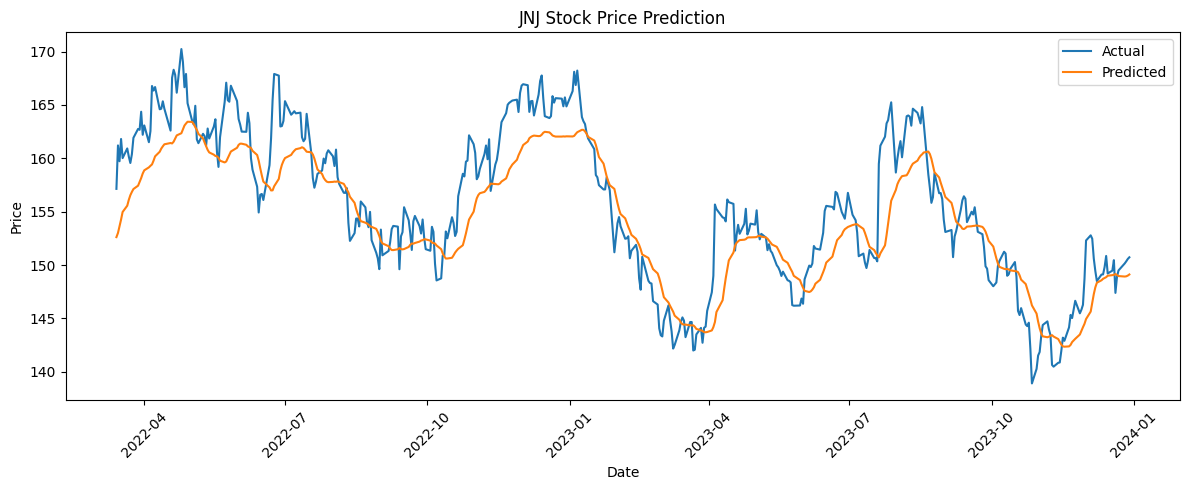

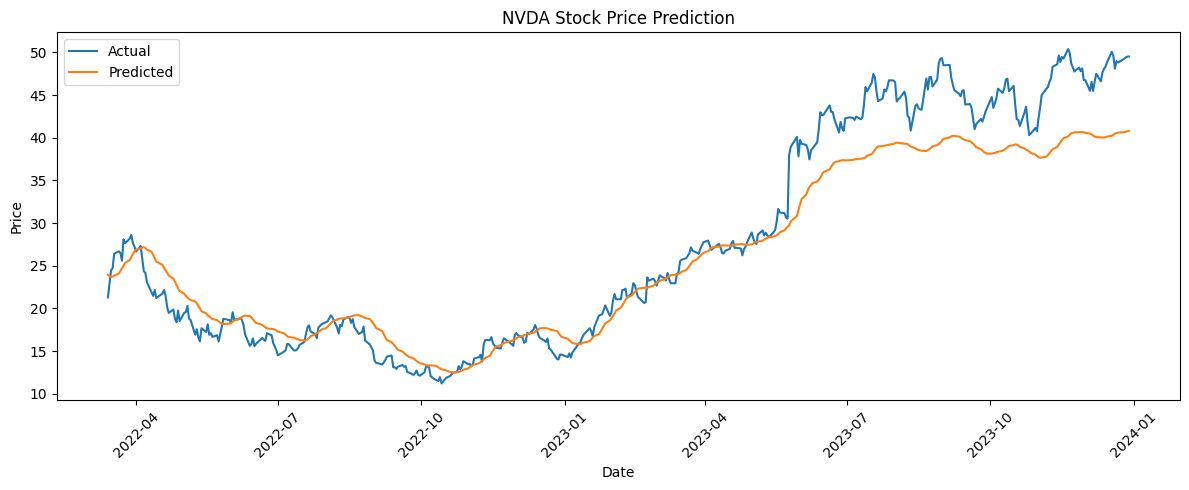

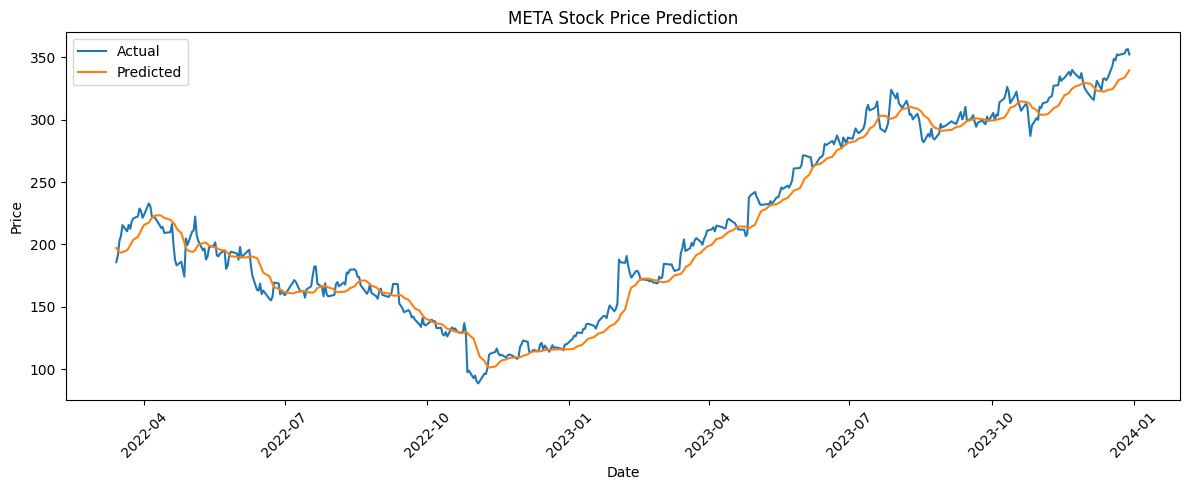

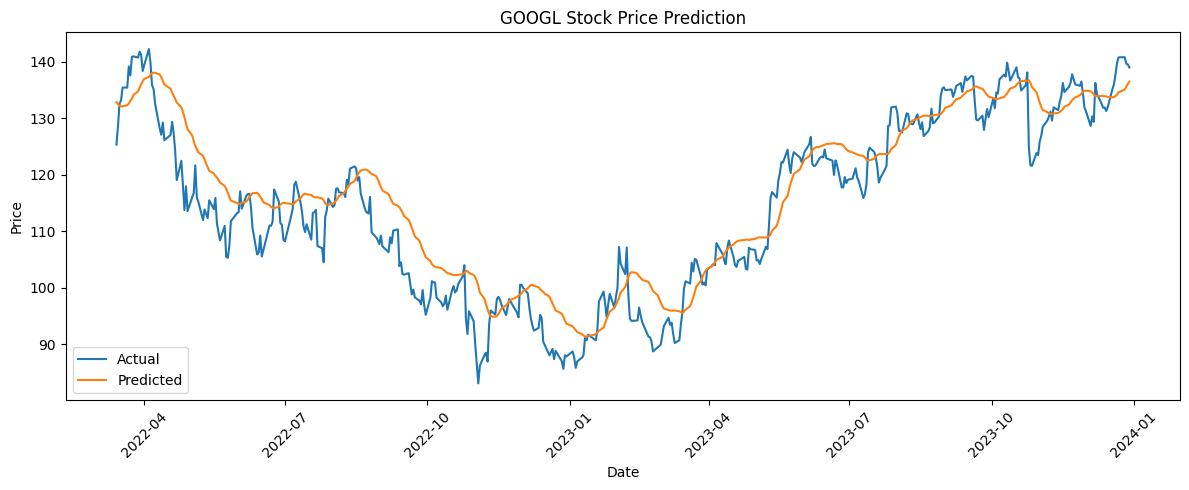

In [5]:
# Plot results with date x-axis
test_dates = data.index[len(data) - len(actual):]  # align with test labels

for ticker in tickers:
    actual, predicted = results[ticker]
    test_dates = data.index[-len(actual):]  # get matching dates from original DataFrame

    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, actual, label='Actual')
    plt.plot(test_dates, predicted, label='Predicted')
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
